In [ ]:
#Instalar paquetes necesarios para hacer el ejercicio

# Cargar los datos en un formato adecuado para entrenar y probar el modelo.

In [ ]:
#Cargar librerias
import os
import shutil
import random
import zipfile
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import precision_score, recall_score, f1_score
from IPython.display import Image, display
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score
warnings.filterwarnings("ignore")


In [ ]:
#Descargar los datos desde un servidor remoto con el comando wget
#Descargar perros y gatos
!wget https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip
#Descargar aves
!wget https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar

--2024-02-03 15:51:25--  https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/zip]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   110MB/s    in 6.4s    

2024-02-03 15:51:32 (123 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]

--2024-02-03 15:51:32--  https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [ ]:
#Genrar directorios para guardar los archivos zip y tar
cats_and_dogs_zip = '/content/kagglecatsanddogs_3367a.zip'
caltech_birds_tar = '/content/CUB_200_2011.tar'
#Generar directorio tmp para trabajar en colab
base_dir = '/tmp/data'

In [ ]:
#Decodificar las imágenes de los formatos zip y tar
with zipfile.ZipFile(cats_and_dogs_zip, 'r') as my_zip:
  my_zip.extractall(base_dir)
with tarfile.open(caltech_birds_tar, 'r') as my_tar:
  my_tar.extractall(base_dir)

In [ ]:
#Directorios de perros y gatos. Las imagenes ya se encuentran separadas en sus respectivas carpetas
base_dogs_dir = os.path.join(base_dir, 'PetImages/Dog')
base_cats_dir = os.path.join(base_dir,'PetImages/Cat')

print(f"There are {len(os.listdir(base_dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(base_cats_dir))} images of cats")

There are 12501 images of dogs
There are 12501 images of cats


In [ ]:
#Directorio de aves. Las imagenes se encuentran en diferentes carpetas y se trata de juntar todas las aves en una sola carpeta
raw_birds_dir = '/tmp/data/CUB_200_2011/images'
base_birds_dir = os.path.join(base_dir,'PetImages/Bird')

#Hacer el directorio si no existe, no correr el código más de una vez ya que se volverá a generar
os.mkdir(base_birds_dir)

for subdir in os.listdir(raw_birds_dir):
  subdir_path = os.path.join(raw_birds_dir, subdir)
  for image in os.listdir(subdir_path):
    shutil.move(os.path.join(subdir_path, image), os.path.join(base_birds_dir))

print(f"There are {len(os.listdir(base_birds_dir))} images of birds")

There are 11788 images of birds


gato


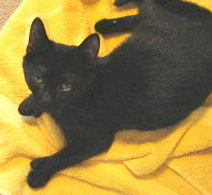

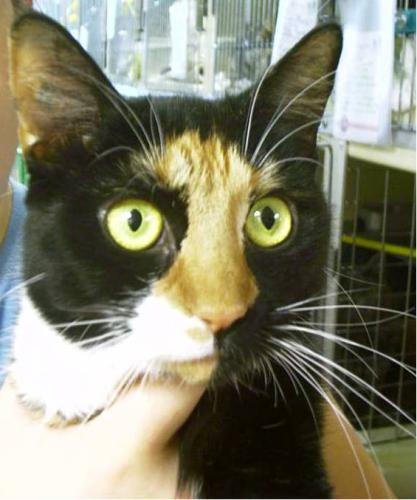

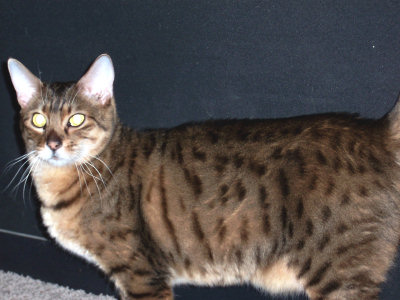

perro


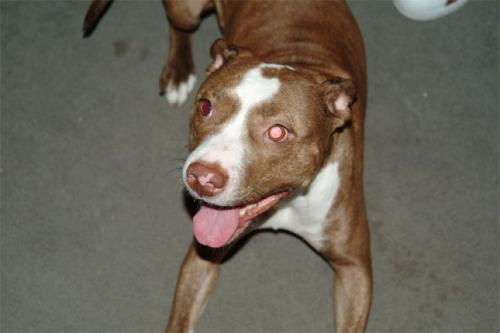

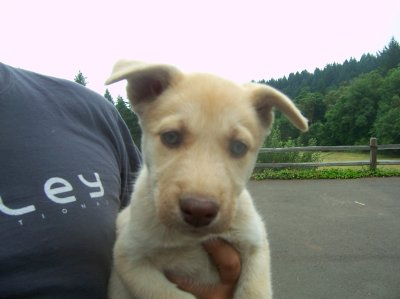

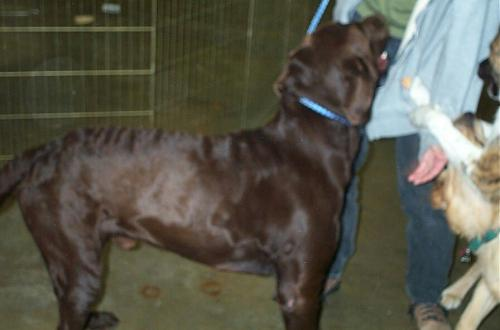

ave


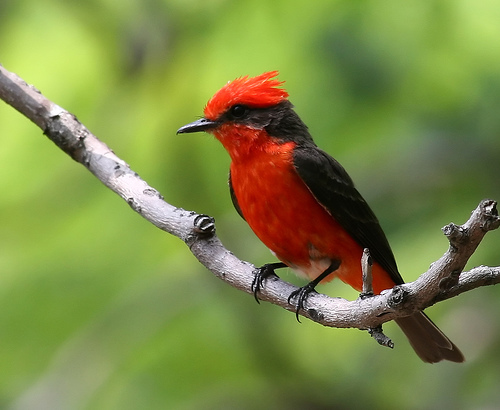

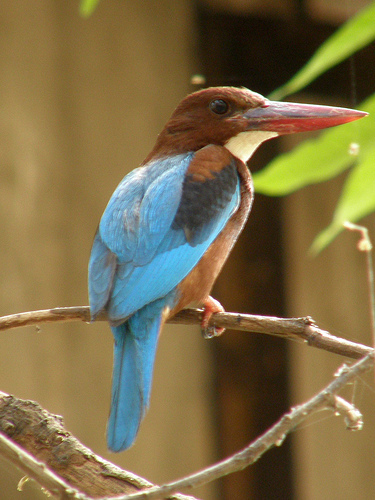

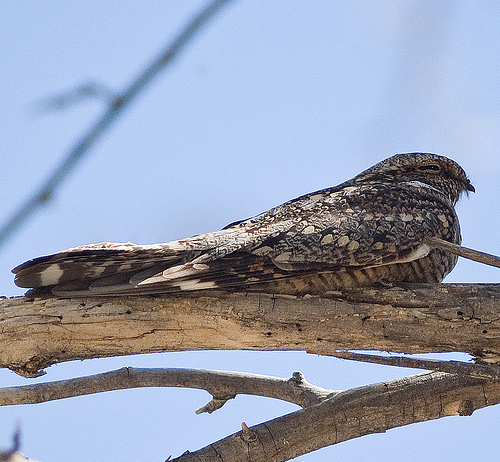

In [ ]:
#Imprimir algún ejemplo de imágen

print("gato")
gatos = os.listdir(base_cats_dir)[:3]
for cat_image in gatos:
    display(Image(filename=os.path.join(base_cats_dir, cat_image)))

print("perro")
perros = os.listdir(base_dogs_dir)[:3]
for dog_image in perros:
    display(Image(filename=os.path.join(base_dogs_dir, dog_image)))

print("ave")
aves = os.listdir(base_birds_dir)[:3]
for bird_image in aves:
    display(Image(filename=os.path.join(base_birds_dir, bird_image)))


# Pre-procesa los datos de entrenamiento y prueba, incluyendo la normalización y el re dimensionamiento de las imágenes según sea necesario.


In [ ]:
#Se hará un redimensionamiento diviendo la imágen entre 255.0 más adelante, si hay que incluir normalización se introudciara en capas dentro de la red

# Diseña y entrena un modelo de clasificación de imágenes utilizando el conjunto de datos de entrenamiento. Puedes elegir el tipo de modelo que consideres adecuado (por ejemplo, una red neuronal convolucional).

In [ ]:
#Directorios de entrenamiento y test
train_eval_dirs = ['train/cats', 'train/dogs', 'train/birds',
                   'eval/cats', 'eval/dogs', 'eval/birds']

for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, dir)):
    os.makedirs(os.path.join(base_dir, dir))

In [ ]:
#Separar las imaganes en entrenamiento y test, creando un umbral % de separación
def move_to_destination(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.move(os.path.join(origin, image_name), destination)

#Entranamiento
move_to_destination(base_cats_dir, os.path.join(base_dir, 'train/cats'), 0.7)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'train/dogs'), 0.7)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'train/birds'), 0.7)

#Valiadación
move_to_destination(base_cats_dir, os.path.join(base_dir, 'eval/cats'), 1)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'eval/dogs'), 1)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'eval/birds'), 1)

In [ ]:
#Eliminar imagenes corruptas con comandos bash, eliminar las imagenes que no tengan peso, osea 0 bytes y eliminar las imagenes con formatos extraños, solo se conserva jpg
!find /tmp/data/ -size 0 -exec rm {} +
!find /tmp/data/ -type f ! -name "*.jpg" -exec rm {} +

In [ ]:
#ver como se han separado mis imagenes en entrenamiento y validación
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 8749 images of dogs for training
There are 8251 images of birds for training

There are 3749 images of cats for evaluation
There are 3750 images of dogs for evaluation
There are 3537 images of birds for evaluation


In [ ]:
#Crear un arquitectura CNN. hago una sencilla para luego mejorarla
def create_model():
  #Usar sequential para iniciar la red
  model = models.Sequential([
  #Probar con 32 filtros, un escaner de 3,3. poner el input_shape en base a la altura y la anchura de la imaages, y 3 dimensiones de RGB
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  #Reducir dimensionalidad sin perder calidad
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  #Aplanar todas la capas para conectar las capas CNN con las capas densas de la red
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  #usar la funcion de activación softmax para un problema de clasificación multiclase
  layers.Dense(3, activation='softmax')
  ])

  model.compile(
      #CategoricalCrossEntropy para hacer la pérdida en un problema de clasificación multiclase
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      #Optimizador Adam, ya que cuenta con inercia y se va haciendo más grande o pequeño en función de encotnrar el punto más bajo
      optimizer=optimizers.Adam(),
      #Evaluar
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  return model

In [ ]:
#Instanciar el modelo
model = create_model()
#ver la capas de la red
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [ ]:
#Normalizar los datos diviendo 255, crear las variables de entrenamiento y validacion indicando su directorio
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        #Altura y anchura de imagen
        target_size=(150, 150),
        #Lotes de entrada de imagenes a la red
        batch_size=32,
        #Etiquetar con 0,1,2 mis perros,gatos y aves
        class_mode='sparse')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='sparse')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


In [ ]:
#Imprimir etiquetas
print(f"labels for each class in the train generator are: {train_generator.class_indices}")
print(f"labels for each class in the validation generator are: {validation_generator.class_indices}")

labels for each class in the train generator are: {'birds': 0, 'cats': 1, 'dogs': 2}
labels for each class in the validation generator are: {'birds': 0, 'cats': 1, 'dogs': 2}


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=80,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=80)

Epoch 1/5
80/80 [==============================] - 22s 206ms/step - loss: 0.9578 - sparse_categorical_accuracy: 0.4934 - val_loss: 0.8286 - val_sparse_categorical_accuracy: 0.6000
Epoch 2/5
80/80 [==============================] - 17s 217ms/step - loss: 0.8003 - sparse_categorical_accuracy: 0.6027 - val_loss: 0.8193 - val_sparse_categorical_accuracy: 0.6223
Epoch 3/5
80/80 [==============================] - 16s 203ms/step - loss: 0.7173 - sparse_categorical_accuracy: 0.6496 - val_loss: 0.7367 - val_sparse_categorical_accuracy: 0.6391
Epoch 4/5
80/80 [==============================] - 12s 150ms/step - loss: 0.7188 - sparse_categorical_accuracy: 0.6520 - val_loss: 0.7322 - val_sparse_categorical_accuracy: 0.6547
Epoch 5/5
80/80 [==============================] - 12s 145ms/step - loss: 0.6849 - sparse_categorical_accuracy: 0.6695 - val_loss: 0.6785 - val_sparse_categorical_accuracy: 0.6969


# Evalúa el rendimiento del modelo utilizando el conjunto de datos de prueba. Calcula métricas como precisión, recall, F1-score y matriz de confusión.


In [ ]:
#sacar las métricas accuracy y loss de la red
def get_training_metrics(history):
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history

  acc = history['sparse_categorical_accuracy']
  val_acc = history['val_sparse_categorical_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

In [ ]:
#imprimir las métricas de evaluación
def plot_train_eval(history):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title('training vs evaluation accuracy')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()

  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title('training vs evaluation loss')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.show()

In [ ]:
#Generar el flujo de datos de validación sin mezclar para calcular métricas adicionales fácilmente
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',  # Directorio que contiene las imágenes de evaluación (validación)
    target_size=(150, 150),        # Tamaño al que se redimensionarán todas las imágenes de entrada
    batch_size=32,                 # Tamaño de los lotes de datos generados
    class_mode='sparse',           # Modo de clasificación de las etiquetas
    shuffle=False                  # No mezclar los datos de validación
)


Found 11036 images belonging to 3 classes.


In [ ]:
#Obtener las etiquetas verdaderas del generador
y_true = val_gen_no_shuffle.classes

#Usar el modelo para hacer predicciones
predictions_imbalanced = model.predict(val_gen_no_shuffle)

#Obtener el índice de la clase con la probabilidad más alta
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

#Imprimir el puntaje de Accuracy
print(f"Puntaje de Precisión: {accuracy_score(y_true, y_pred_imbalanced)}")

# Imprimir el puntaje de precisión equilibrada
print(f"Puntaje de Precisión Equilibrada: {balanced_accuracy_score(y_true, y_pred_imbalanced)}")


345/345 [==============================] - 25s 71ms/step
Puntaje de Precisión: 0.6822218194998187
Puntaje de Precisión Equilibrada: 0.683658626056761


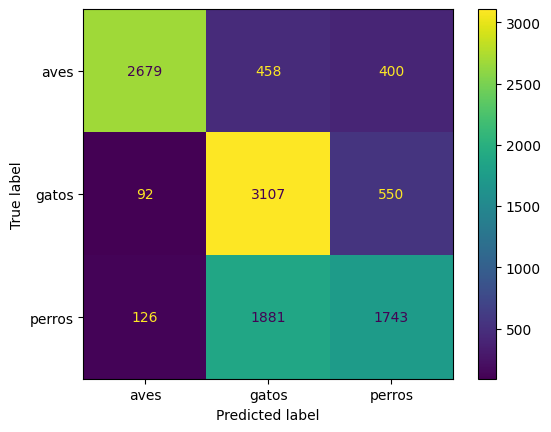

In [ ]:
#matrix de confusión
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['aves', 'gatos', 'perros']).plot(values_format="d")

In [ ]:
#Imprimir f1, recall y precisión
precision = precision_score(y_true, y_pred_imbalanced, average='weighted')
recall = recall_score(y_true, y_pred_imbalanced, average='weighted')
f1 = f1_score(y_true, y_pred_imbalanced, average='weighted')
print(precision)
print(recall)
print(f1)

0.7101132162695835
0.6822218194998187
0.6803200790101545


# Visualiza algunos ejemplos de imágenes mal clasificadas junto con las etiquetas reales y predichas.


In [ ]:
#Generar dos funciones para visualizar el resultado de las imagenes con el modelo

import matplotlib.pyplot as plt

def plot_image_misclassified(i, y_pred, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(y_pred)

    # Muestra el texto con la etiqueta predicha y la probabilidad
    plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label], 100 * np.max(y_pred)), color='blue')


def plot_value_array_misclassified(i, y_pred):
    plt.grid(False)
    plt.xticks(range(3))
    plt.yticks([])
    thisplot = plt.bar(range(3), y_pred, color="#777777")
    plt.ylim([0, 1])

    predicted_label = np.argmax(y_pred)  #Obtiene la etiqueta predicha con mayor probabilidad
    # true_label = int(y_true)              #Obtiene la etiqueta verdadera del dato, para hacer el cáculo

    thisplot[predicted_label].set_color('red')
    # thisplot[true_label].set_color('blue')


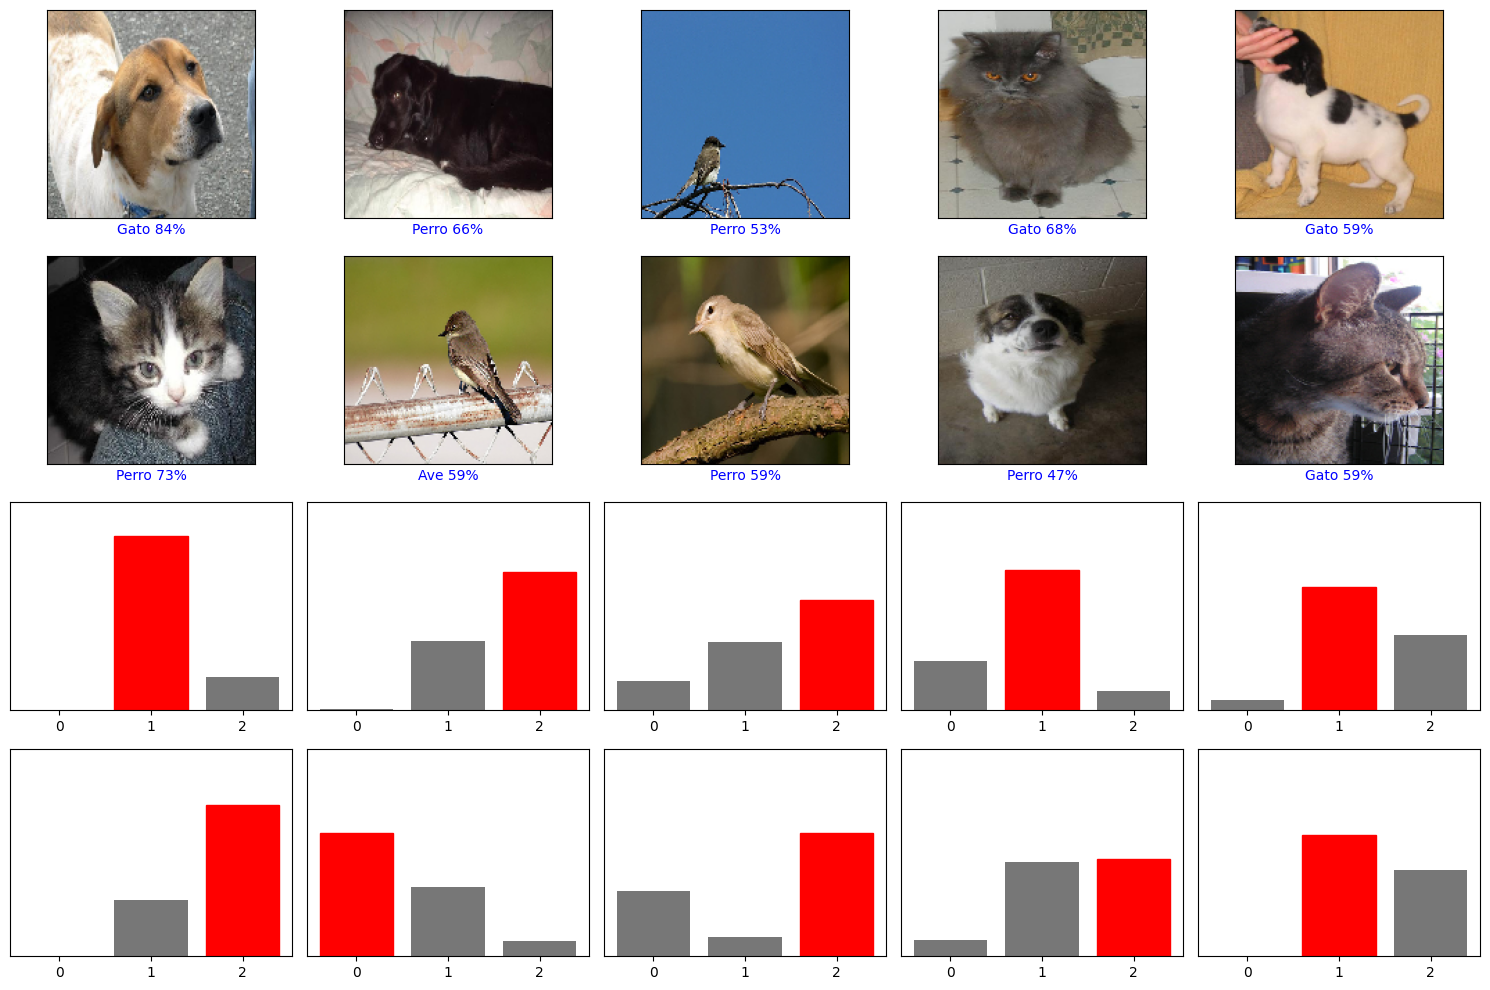

In [ ]:
import random

class_names = ['Ave', 'Gato', 'Perro']

misclassified_indices = np.where(y_pred_imbalanced != y_true)[0]

# Verifica si hay suficientes índices mal clasificados
if len(misclassified_indices) < 10:
    print("No hay suficientes ejemplos mal clasificados para mostrar.")
else:
    # Elegir aleatoriamente una muestra de 10 índices de imágenes mal clasificadas
    sample_indices = random.sample(list(misclassified_indices), 10)

    # Imprimir ejemplos de imágenes mal clasificadas
    plt.figure(figsize=(15, 10))
    for i, index in enumerate(sample_indices):
        plt.subplot(4, 5, i + 1)  # Ajuste del número de columnas para acomodar los ejemplos de imágenes y los gráficos de barras
        plot_image_misclassified(index, predictions_imbalanced[index], val_gen_no_shuffle[index % len(val_gen_no_shuffle)][0][0], class_names)

        # plt.title(f'Imagen Real: {class_names[y_true[index]]}')  # Añadir título con la clase real de la imagen
        plt.subplot(4, 5, i + 11)  # Ajuste del índice para el segundo conjunto de subgráficos
        plot_value_array_misclassified(index, predictions_imbalanced[index])
    plt.tight_layout()
    plt.show()


# Optimiza el modelo si es necesario para mejorar su rendimiento.

In [ ]:
#Mejorar con Dropout y subiendo filtros

def model2():
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),  #Capa de Dropout para regularización

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(3, activation='softmax')
    ])

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizers.Adam(0.005),  #hacer el optimizador más pequeño para buscar más lentamente el menor error
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

    return model


In [ ]:
model2 = create_model()
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 64)       

In [ ]:
history = model2.fit(
    train_generator,
    steps_per_epoch=80,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=80)

Epoch 1/20
80/80 [==============================] - 16s 203ms/step - loss: 0.6379 - sparse_categorical_accuracy: 0.7086 - val_loss: 0.6959 - val_sparse_categorical_accuracy: 0.6691
Epoch 2/20
80/80 [==============================] - 12s 146ms/step - loss: 0.6557 - sparse_categorical_accuracy: 0.6918 - val_loss: 0.6680 - val_sparse_categorical_accuracy: 0.7035
Epoch 3/20
80/80 [==============================] - 12s 154ms/step - loss: 0.6233 - sparse_categorical_accuracy: 0.7164 - val_loss: 0.6444 - val_sparse_categorical_accuracy: 0.7094
Epoch 4/20
80/80 [==============================] - 12s 145ms/step - loss: 0.6303 - sparse_categorical_accuracy: 0.7328 - val_loss: 0.6158 - val_sparse_categorical_accuracy: 0.7188
Epoch 5/20
80/80 [==============================] - 16s 203ms/step - loss: 0.5721 - sparse_categorical_accuracy: 0.7410 - val_loss: 0.5899 - val_sparse_categorical_accuracy: 0.7309
Epoch 6/20
80/80 [==============================] - 12s 144ms/step - loss: 0.5544 - sparse_cate

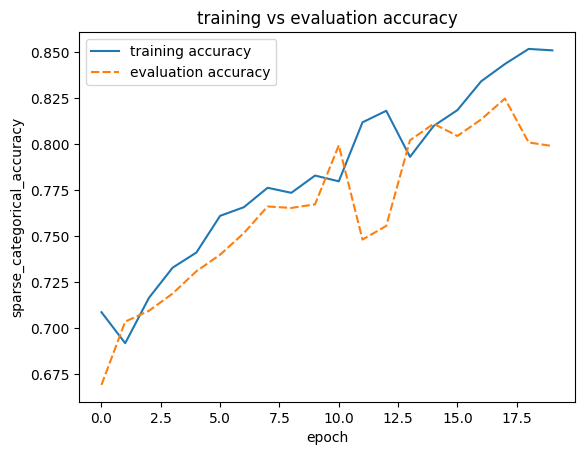

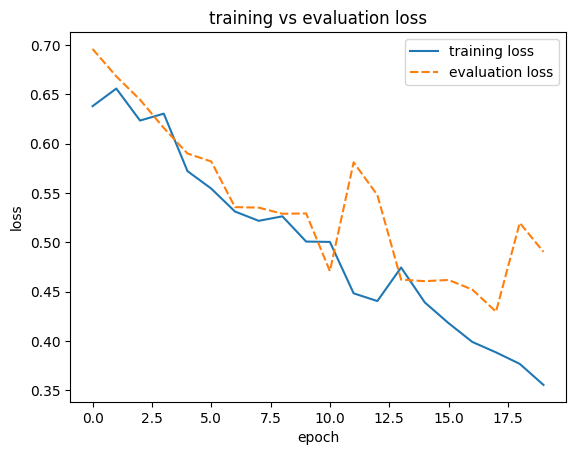

In [ ]:
plot_train_eval(history)

# Evalúa 2


In [ ]:
#sacar las métricas accuracy y loss de la red
def get_training_metrics(history):
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history

  acc = history['sparse_categorical_accuracy']
  val_acc = history['val_sparse_categorical_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

In [ ]:
#imprimir las métricas de evaluación
def plot_train_eval(history):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title('training vs evaluation accuracy')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()

  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title('training vs evaluation loss')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.show()

In [ ]:
#Generar el flujo de datos de validación sin mezclar para calcular métricas adicionales fácilmente
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',  # Directorio que contiene las imágenes de evaluación (validación)
    target_size=(150, 150),        # Tamaño al que se redimensionarán todas las imágenes de entrada
    batch_size=32,                 # Tamaño de los lotes de datos generados
    class_mode='sparse',           # Modo de clasificación de las etiquetas
    shuffle=False                  # No mezclar los datos de validación
)


Found 11036 images belonging to 3 classes.


In [ ]:
#Obtener las etiquetas verdaderas del generador
y_true = val_gen_no_shuffle.classes

#Usar el modelo para hacer predicciones
predictions_imbalanced = model2.predict(val_gen_no_shuffle)

#Obtener el índice de la clase con la probabilidad más alta
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

#Imprimir el puntaje de Accuracy
print(f"Puntaje de Precisión: {accuracy_score(y_true, y_pred_imbalanced)}")

# Imprimir el puntaje de precisión equilibrada
print(f"Puntaje de Precisión Equilibrada: {balanced_accuracy_score(y_true, y_pred_imbalanced)}")


345/345 [==============================] - 24s 69ms/step
Puntaje de Precisión: 0.7962123957955781
Puntaje de Precisión Equilibrada: 0.7973436754095378


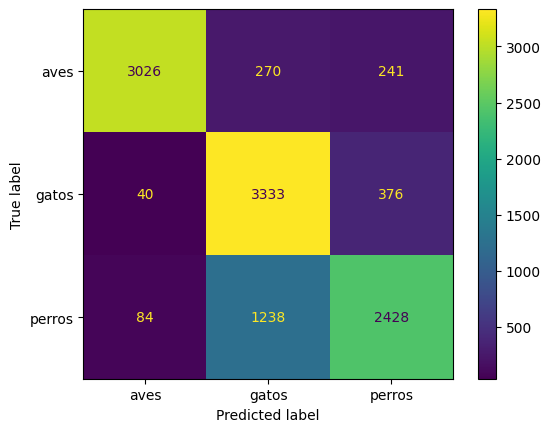

In [ ]:
#matrix de confusión
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['aves', 'gatos', 'perros']).plot(values_format="d")

In [ ]:
#Imprimir f1, recall y precisión
precision = precision_score(y_true, y_pred_imbalanced, average='weighted')
recall = recall_score(y_true, y_pred_imbalanced, average='weighted')
f1 = f1_score(y_true, y_pred_imbalanced, average='weighted')
print(precision)
print(recall)
print(f1)

0.8127109393234834
0.7962123957955781
0.7965141988085404
